In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.22.2', 'qiskit-aer': '0.11.1', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.39.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit import *

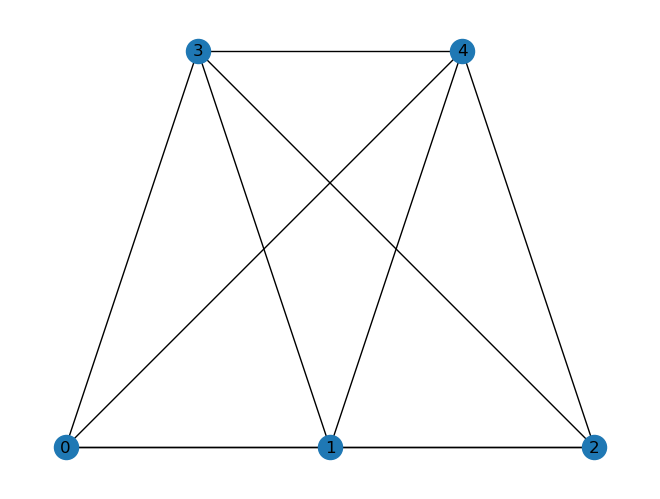

In [3]:
"""G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G, pos=nx.bipartite_layout(G, [0,1,2]))"""

seed = 452002
G = nx.complete_graph(5)
pos = {
    0: (0, 0),
    1: (1, 0),
    2: (2, 0),
    3: (0.5, 1),
    4: (1.5, 1),
}
nx.draw(G, pos=pos, with_labels=True)

In [4]:
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc
    

In [5]:
qc = get_cost_operator_circuit(G, np.pi / 3)
qc.draw()

»
q_0: ──■────────────────■────■────────────────■────■──────────────────────────»
     ┌─┴─┐┌──────────┐┌─┴─┐  │                │    │                          »
q_1: ┤ X ├┤ Rz(2π/3) ├┤ X ├──┼────────────────┼────┼───────■──────────────────»
     └───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐  │     ┌─┴─┐    ┌──────────┐»
q_2: ──────────────────────┤ X ├┤ Rz(2π/3) ├┤ X ├──┼─────┤ X ├────┤ Rz(2π/3) ├»
                           └───┘└──────────┘└───┘┌─┴─┐┌──┴───┴───┐└──────────┘»
q_3: ────────────────────────────────────────────┤ X ├┤ Rz(2π/3) ├────────────»
                                                 └───┘└──────────┘            »
q_4: ─────────────────────────────────────────────────────────────────────────»
                                                                              »
c_0: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_1: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_2: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_3: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_4: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                                       »
«q_0: ──■─────────■────────────────────────────■────────────────────────»
«       │         │                            │                        »
«q_1: ──┼────■────┼───────■────────────────────┼────■────■──────────────»
«       │  ┌─┴─┐  │       │                    │    │    │              »
«q_2: ──┼──┤ X ├──┼───────┼────────────────────┼────┼────┼───────■──────»
«     ┌─┴─┐└───┘  │     ┌─┴─┐    ┌──────────┐  │  ┌─┴─┐  │     ┌─┴─┐    »
«q_3: ┤ X ├───────┼─────┤ X ├────┤ Rz(2π/3) ├──┼──┤ X ├──┼─────┤ X ├────»
«     └───┘     ┌─┴─┐┌──┴───┴───┐└──────────┘┌─┴─┐└───┘┌─┴─┐┌──┴───┴───┐»
«q_4: ──────────┤ X ├┤ Rz(2π/3) ├────────────┤ X ├─────┤ X ├┤ Rz(2π/3) ├»
«               └───┘└──────────┘            └───┘     └───┘└──────────┘»
«c_0: ══════════════════════════════════════════════════════════════════»
«                                                                       »
«c_1: ══════════════════════════════════════════════════════════════════»
«                                                                       »
«c_2: ══════════════════════════════════════════════════════════════════»
«                                                                       »
«c_3: ══════════════════════════════════════════════════════════════════»
«                                                                       »
«c_4: ══════════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                       
«q_0: ──────────────────────────────────────────────────────────────────
«                                                                       
«q_1: ──────────────■───────────────────────────────────────────────────
«                   │                                                   
«q_2: ──────────────┼────■────■────────────────■────────────────────────
«     ┌──────────┐  │  ┌─┴─┐  │                │                        
«q_3: ┤ Rz(2π/3) ├──┼──┤ X ├──┼────────────────┼────■────────────────■──
«     └──────────┘┌─┴─┐└───┘┌─┴─┐┌──────────┐┌─┴─┐┌─┴─┐┌──────────┐┌─┴─┐
«q_4: ────────────┤ X ├─────┤ X ├┤ Rz(2π/3) ├┤ X ├┤ X ├┤ Rz(2π/3) ├┤ X ├
«                 └───┘     └───┘└──────────┘└───┘└───┘└──────────┘└───┘
«c_0: ═══════════════════════════════════

In [6]:
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc

In [7]:
qc = get_mixer_operator_circuit(G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ Rx(2π/3) ├
     ├──────────┤
q_1: ┤ Rx(2π/3) ├
     ├──────────┤
q_2: ┤ Rx(2π/3) ├
     ├──────────┤
q_3: ┤ Rx(2π/3) ├
     ├──────────┤
q_4: ┤ Rx(2π/3) ├
     └──────────┘
c_0: ════════════
                 
c_1: ════════════
                 
c_2: ════════════
                 
c_3: ════════════
                 
c_4: ════════════

In [8]:
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc

In [9]:
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw()

C:\Users\prath\AppData\Local\Temp\ipykernel_30868\1074017623.py:10: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(G,gamma[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_30868\1074017623.py:11: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_mixer_operator_circuit(G,beta[i])


┌───┐                                                                  »
q_0: ┤ H ├──■─────────────■────■─────────────■────■──────────────────────■──»
     ├───┤┌─┴─┐┌───────┐┌─┴─┐  │             │    │                      │  »
q_1: ┤ H ├┤ X ├┤ Rz(π) ├┤ X ├──┼─────────────┼────┼──────■───────────────┼──»
     ├───┤└───┘└───────┘└───┘┌─┴─┐┌───────┐┌─┴─┐  │    ┌─┴─┐  ┌───────┐  │  »
q_2: ┤ H ├───────────────────┤ X ├┤ Rz(π) ├┤ X ├──┼────┤ X ├──┤ Rz(π) ├──┼──»
     ├───┤                   └───┘└───────┘└───┘┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐»
q_3: ┤ H ├──────────────────────────────────────┤ X ├┤ Rz(π) ├─────────┤ X ├»
     ├───┤                                      └───┘└───────┘         └───┘»
q_4: ┤ H ├──────────────────────────────────────────────────────────────────»
     └───┘                                                                  »
c_0: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_1: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_2: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_3: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_4: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                      ┌──────────┐                            »
«q_0: ───────■──────────────────────■──┤ Rx(2π/3) ├────────────────────────────»
«            │                      │  └──────────┘                            »
«q_1: ──■────┼──────■───────────────┼───────■────────■──────────────────────■──»
«     ┌─┴─┐  │      │               │       │        │                      │  »
«q_2: ┤ X ├──┼──────┼───────────────┼───────┼────────┼──────■───────────────┼──»
«     └───┘  │    ┌─┴─┐  ┌───────┐  │     ┌─┴─┐      │    ┌─┴─┐  ┌───────┐  │  »
«q_3: ───────┼────┤ X ├──┤ Rz(π) ├──┼─────┤ X ├──────┼────┤ X ├──┤ Rz(π) ├──┼──»
«          ┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐   └───┘    ┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐»
«q_4: ─────┤ X ├┤ Rz(π) ├─────────┤ X ├────────────┤ X ├┤ Rz(π) ├─────────┤ X ├»
«          └───┘└───────┘         └───┘            └───┘└───────┘         └───┘»
«c_0: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_1: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_2: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_3: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_4: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                           ░ »
«q_0: ──────────────────────────────────────────────────────────────────────░─»
«     ┌──────────┐                                                          ░ »
«q_1: ┤ Rx(2π/3) ├──────────────────────────────────────────────────────────░─»
«     └──────────┘                   ┌──────────┐                           ░ »
«q_2: ─────■────────■─────────────■──┤ Rx(2π/3) ├───────────────────────────░─»
«        ┌─┴─┐      │             │  └──────────┘              ┌──────────┐ ░ »
«q_3: ───┤ X ├──────┼─────────────┼───────■─────────────────■──┤ Rx(2π/3) ├─░─»
«        └───┘    ┌─┴─┐┌──

In [10]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [11]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairo

In [12]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_quito')
qbackend = Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2023-03-14 17:42:16,488: Credentials are already in use. The existing account in the session will be replaced.


In [13]:
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))

jobq = execute(qc, qbackend)
result = job.result()
print(invert_counts(result.get_counts()))

{'00000': 128, '10000': 129, '00001': 120, '10001': 148, '01001': 85, '11001': 122, '00101': 142, '10101': 149, '01101': 89, '11101': 161, '00011': 105, '10011': 136, '01011': 134, '11011': 158, '00111': 129, '10111': 123, '01111': 143, '11111': 192, '01000': 80, '11000': 128, '00100': 107, '10100': 128, '01100': 75, '11100': 151, '00010': 89, '10010': 116, '01010': 89, '11010': 125, '00110': 106, '10110': 148, '01110': 106, '11110': 159}
{'00000': 128, '10000': 129, '00001': 120, '10001': 148, '01001': 85, '11001': 122, '00101': 142, '10101': 149, '01101': 89, '11101': 161, '00011': 105, '10011': 136, '01011': 134, '11011': 158, '00111': 129, '10111': 123, '01111': 143, '11111': 192, '01000': 80, '11000': 128, '00100': 107, '10100': 128, '01100': 75, '11100': 151, '00010': 89, '10010': 116, '01010': 89, '11010': 125, '00110': 106, '10110': 148, '01110': 106, '11110': 159}


In [14]:
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

maxcut_obj('00011', G)

-6

In [15]:
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-4.8855

In [16]:
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

In [17]:
p = 1
obj = get_black_box_objective(G, p)

my_array = []

for i in range(2*p):
    my_array.append(random.randint(0, 2))
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample

NameError: name 'random' is not defined

In [ ]:
backend = provider.get_backend('ibmq_quito')
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())
counts

In [ ]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k,G)] += v

x,y = zip(*energies.items())
plt.bar(x,y)

In [ ]:
# get the best solution:
best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=pos)